In [1]:
import cv2
import numpy as np
import requests

%matplotlib inline

print cv2.__version__

3.1.0


In [2]:
def read_rgb_image_from_web(image_url):
    response = requests.get(image_url)
    encoded_image_buf = np.fromstring(response.content, dtype=np.uint8)
    decoded_image_bgr = cv2.imdecode(encoded_image_buf, cv2.IMREAD_COLOR)
    return cv2.cvtColor(decoded_image_bgr, cv2.COLOR_BGR2RGB)

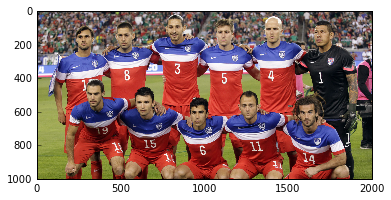

In [3]:
image_url = 'http://i.huffpost.com/gen/1719218/images/o-SOCCER-MEXICO-facebook.jpg'
image_rgb = read_rgb_image_from_web(image_url)

plt.imshow(image_rgb)

In [4]:
FACE_CASCADE = cv2.CascadeClassifier("webapp/resources/cascades/haarcascades/haarcascade_frontalface_alt.xml")
EYE_CASCADE = cv2.CascadeClassifier("webapp/resources/cascades/haarcascades/haarcascade_eye.xml")

In [5]:
def eye_regions(face_rect):
    side_inset = 0.1
    top_inset = 0.2
    bottom_inset = 0.35
    x, y, width, height = face_rect

    left_eye_rect  = (x + width*side_inset,
                      y + height*top_inset,
                      width*(0.5-side_inset), 
                      height*(1-top_inset-bottom_inset))
    right_eye_rect = (x + 0.5*width,
                      y + height*top_inset,
                      width*(0.5-side_inset),
                      height*(1-top_inset-bottom_inset))

    eye_rects = [left_eye_rect, right_eye_rect]
    return [tuple([int(round(v)) for v in rect]) for rect in eye_rects]


def process_photo(image_rgb, annotated_rgb):
    image_gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    #image_gray = cv2.equalizeHist(image_gray)

    faces = FACE_CASCADE.detectMultiScale(image_gray,
                                          scaleFactor=1.1,
                                          minNeighbors=3,
                                          minSize=(45, 45),
                                          flags = cv2.CASCADE_SCALE_IMAGE)

    face_color = [0, 0, 255]
    eye_color = [0, 255, 0]
    thickness = 4

    for x_face, y_face, w_face, h_face in faces:

        for x_roi, y_roi, w_roi, h_roi in eye_regions((x_face, y_face, w_face, h_face)): 
            
            image_eye_rio_gray = image_gray[y_roi : y_roi + h_roi,
                                            x_roi : x_roi + w_roi]

            eyes = EYE_CASCADE.detectMultiScale(image_eye_rio_gray,
                                                scaleFactor=1.05,
                                                minNeighbors=3,
                                                minSize=(15, 15),
                                                flags = cv2.CASCADE_SCALE_IMAGE)
            if len(eyes) == 0:
                continue

            x_eye, y_eye, w_eye, h_eye = eyes[0]

            cv2.rectangle(annotated_rgb,
                          (x_roi + x_eye,         y_roi + y_eye),
                          (x_roi + x_eye + w_eye, y_roi + y_eye + h_eye),
                          eye_color, thickness)
        
        cv2.rectangle(annotated_rgb,
                      (x_face,          y_face),
                      (x_face + w_face, y_face + h_face),
                      face_color, thickness)

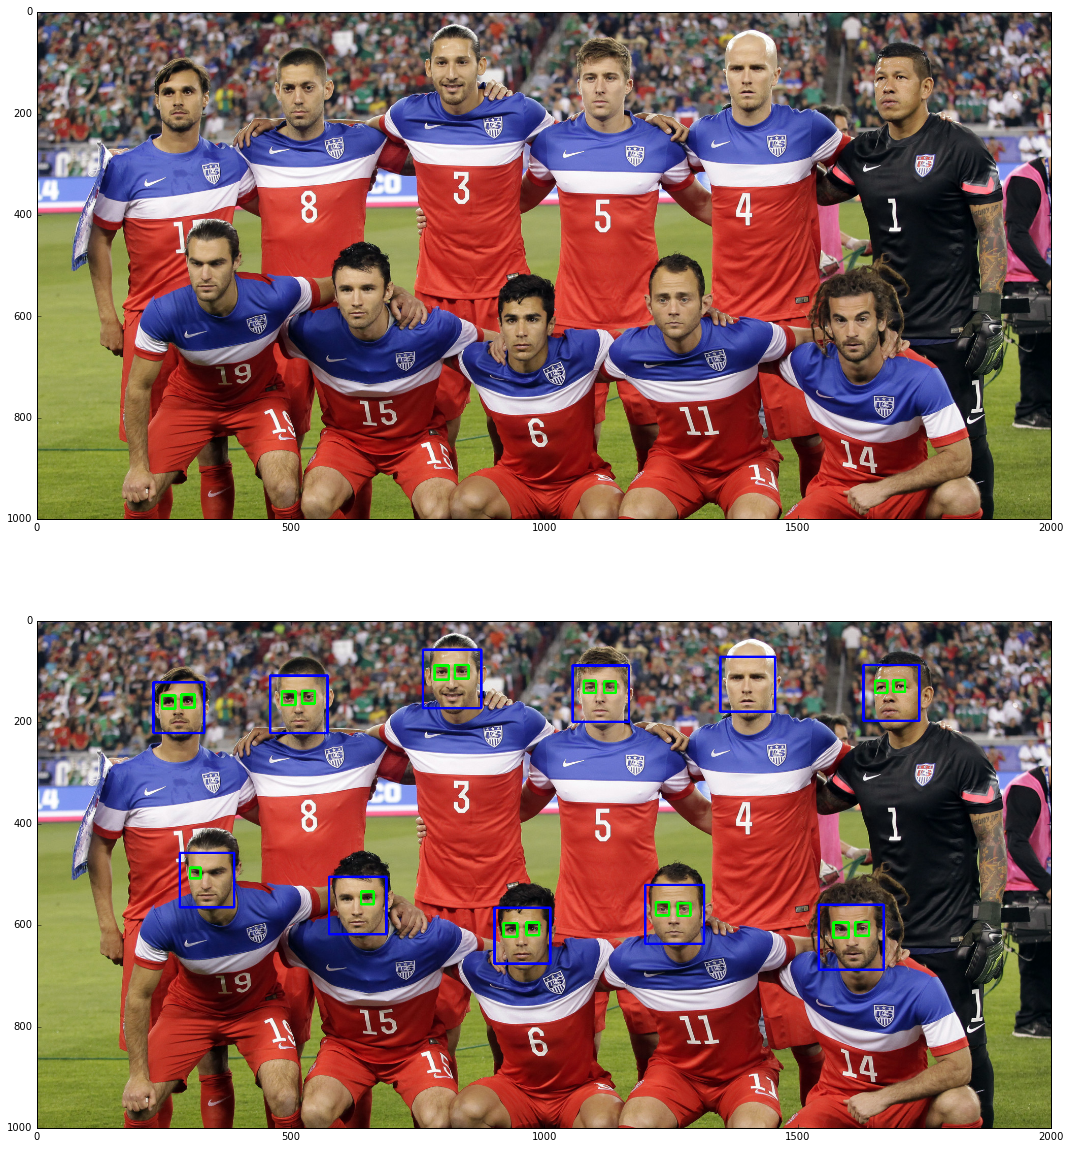

In [6]:
annotated_rgb = np.copy(image_rgb)

process_photo(image_rgb, annotated_rgb)

fig, axes = plt.subplots(2, 1, figsize=(20, 20))
axes[0].imshow(image_rgb)
axes[1].imshow(annotated_rgb)